<a href="https://colab.research.google.com/github/askmuhsin/Session_5_assignment/blob/main/Experiment_5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Target:
* Add Dropout of 0.05
* Start with LR at 0.2, and ReduceLROnPlateau with a reduction factor of 0.5 when no imporvement in `test_loss` for 2 Epochs. Since the factor is a bit high setting min_lr to 0.001
 
# Results:
* Parameters: 9,958
* Best Training Accuracy: 98.35% (EPOCH 14)
* Best Test Accuracy: 99.46% (EPOCH 13) 99.48 (EPOCH 19)
 
# Analysis:
* by adding step lr and Dropout of 0.05, the training is even more stable.
* consistent test accuracy around 99.4 observed from epoch 13.
* The LR was reduced at EPOCH 12.
* Since the model is underfitting till EPOCH 20, training for more epochs OR removing regularizations would be helpful.


# Import Libraries

In [1]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt

from torchvision import datasets, transforms
import torchvision

## Data Transformations

We first start with defining our data transformations. We need to think what our data is and how can we augment it to correct represent images which it might not see otherwise. 


In [2]:
# Train Phase transformations
train_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                      #  transforms.RandomAffine(
                                      #     degrees=0,
                                      #     scale=(0.8, 0.9),
                                      #     shear=3
                                      #  ),
                                       transforms.RandomRotation((-7.0, 7.0), fill=(1,)),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,)), # The mean and std have to be sequences (e.g., tuples), therefore you should add a comma after the values. 
                                       # Note the difference between (0.1307) and (0.1307,)
                                       transforms.RandomErasing(p=0.5, scale=(0.02, 0.15), ratio=(0.3, 3.3), value=0)
                                       ])

# Test Phase transformations
test_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,))
                                       ])


# Dataset and Creating Train/Test Split

In [3]:
train = datasets.MNIST('./data', train=True, download=True, transform=train_transforms)
test = datasets.MNIST('./data', train=False, download=True, transform=test_transforms)


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw




Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw




Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw




Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw

Processing...
Done!


/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:502: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:143.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


# Dataloader Arguments & Test/Train Dataloaders


In [4]:
SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=128, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

# train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

CUDA Available? True


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


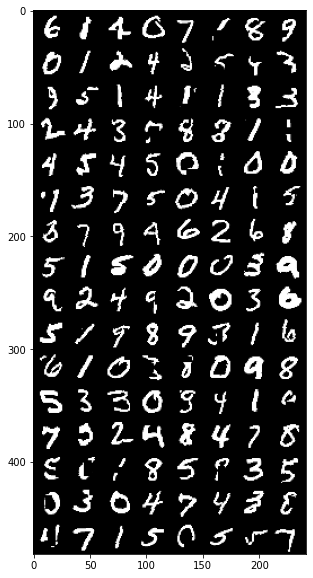

In [5]:
for data, target in train_loader:
  break
grid_img = torchvision.utils.make_grid(data.cpu().detach())
plt.figure(figsize=(10, 10))
plt.imshow(grid_img.permute(1, 2, 0))

# The model
Let's start with the model we first saw

In [6]:
import torch.nn.functional as F
dropout_value = 0.05
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # CONVOLUTION BLOCK 1
        self.convblock1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=6, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(6),
            nn.Dropout(dropout_value)
        ) # output_size = 26

        # CONVOLUTION BLOCK 2
        self.convblock2 = nn.Sequential(
            nn.Conv2d(in_channels=6, out_channels=12, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(12),
            nn.Dropout(dropout_value)
        ) # output_size = 24

        # TRANSITION BLOCK 1
        self.convblock3 = nn.Sequential(
            nn.Conv2d(in_channels=12, out_channels=7, kernel_size=(1, 1), padding=0, bias=False),
        ) # output_size = 24

        self.pool1 = nn.MaxPool2d(2, 2) # output_size = 12

        # CONVOLUTION BLOCK 4
        self.convblock4 = nn.Sequential(
            nn.Conv2d(in_channels=7, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),            
            nn.BatchNorm2d(16),
            nn.Dropout(dropout_value)
        ) # output_size = 10

         # CONVOLUTION BLOCK 5
        self.convblock5 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),            
            nn.BatchNorm2d(16),
            nn.Dropout(dropout_value)
        ) # output_size = 8
         # CONVOLUTION BLOCK 6
        self.convblock6 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=18, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),            
            nn.BatchNorm2d(18),
            nn.Dropout(dropout_value)
        ) # output_size = 6
         # CONVOLUTION BLOCK 7
        self.convblock7 = nn.Sequential(
            nn.Conv2d(in_channels=18, out_channels=18, kernel_size=(3, 3), padding=1, bias=False),
            nn.ReLU(),            
            nn.BatchNorm2d(18),
            nn.Dropout(dropout_value)
        ) # output_size = 6
        
        # OUTPUT BLOCK
        self.gap = nn.Sequential(
            nn.AvgPool2d(kernel_size=6)
        ) # output_size = 1

        self.convblock8 = nn.Sequential(
            nn.Conv2d(in_channels=18, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),
            # nn.BatchNorm2d(10),
            # nn.ReLU(),
            # nn.Dropout(dropout_value)
        ) 

        # self.dropout = nn.Dropout(dropout_value)

    def forward(self, x):
        x = self.convblock1(x)
        x = self.convblock2(x)

        x = self.convblock3(x)
        x = self.pool1(x)

        x = self.convblock4(x)
        x = self.convblock5(x)
        x = self.convblock6(x)
        x = self.convblock7(x)

        x = self.gap(x)        
        x = self.convblock8(x)

        x = x.view(-1, 10)
        return F.log_softmax(x, dim=-1)

# Model Params
Can't emphasize on how important viewing Model Summary is. 
Unfortunately, there is no in-built model visualizer, so we have to take external help

In [7]:
# !pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = Net().to(device)
summary(model, input_size=(1, 28, 28))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 6, 26, 26]              54
              ReLU-2            [-1, 6, 26, 26]               0
       BatchNorm2d-3            [-1, 6, 26, 26]              12
           Dropout-4            [-1, 6, 26, 26]               0
            Conv2d-5           [-1, 12, 24, 24]             648
              ReLU-6           [-1, 12, 24, 24]               0
       BatchNorm2d-7           [-1, 12, 24, 24]              24
           Dropout-8           [-1, 12, 24, 24]               0
            Conv2d-9            [-1, 7, 24, 24]              84
        MaxPool2d-10            [-1, 7, 12, 12]               0
           Conv2d-11           [-1, 16, 10, 10]           1,008
             ReLU-12           [-1, 16, 10, 10]               0
      BatchNorm2d-13           [-1, 16, 10, 10]              32
          Dropout-14           [-1

# Training and Testing

Looking at logs can be boring, so we'll introduce **tqdm** progressbar to get cooler logs. 

Let's write train and test functions

In [8]:
from tqdm import tqdm

train_losses = []
test_losses = []
train_acc = []
test_acc = []

def train(model, device, train_loader, optimizer, scheduler, epoch):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  train_loss = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes. 
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = F.nll_loss(y_pred, target)
    train_loss += loss.item()
    train_losses.append(loss)

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm
    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)

  # train_loss /= batch_idx
  # scheduler.step(train_loss)
  # print("Avg Train Loss : ", train_loss)

def test(model, device, test_loader, scheduler):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)
    scheduler.step(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    test_acc.append(100. * correct / len(test_loader.dataset))

In [9]:
from torch.optim.lr_scheduler import ReduceLROnPlateau

model =  Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.020, momentum=0.9)
scheduler = ReduceLROnPlateau(
    optimizer, mode='min', factor=0.5, 
    patience=2, min_lr=0.001, verbose=True
)

EPOCHS = 20
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model, device, train_loader, optimizer, scheduler, epoch)
    test(model, device, test_loader, scheduler)

  0%|          | 0/469 [00:00<?, ?it/s]

EPOCH: 0


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
Loss=0.20281128585338593 Batch_id=468 Accuracy=87.39: 100%|██████████| 469/469 [00:18<00:00, 24.96it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0607, Accuracy: 9822/10000 (98.22%)

EPOCH: 1


Loss=0.1358194351196289 Batch_id=468 Accuracy=96.18: 100%|██████████| 469/469 [00:18<00:00, 25.49it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0398, Accuracy: 9878/10000 (98.78%)

EPOCH: 2


Loss=0.11043880134820938 Batch_id=468 Accuracy=96.91: 100%|██████████| 469/469 [00:18<00:00, 25.48it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0377, Accuracy: 9877/10000 (98.77%)

EPOCH: 3


Loss=0.06693217903375626 Batch_id=468 Accuracy=97.22: 100%|██████████| 469/469 [00:18<00:00, 25.19it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0358, Accuracy: 9884/10000 (98.84%)

EPOCH: 4


Loss=0.07382141798734665 Batch_id=468 Accuracy=97.53: 100%|██████████| 469/469 [00:18<00:00, 25.31it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0313, Accuracy: 9898/10000 (98.98%)

EPOCH: 5


Loss=0.20920813083648682 Batch_id=468 Accuracy=97.70: 100%|██████████| 469/469 [00:18<00:00, 25.17it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0290, Accuracy: 9908/10000 (99.08%)

EPOCH: 6


Loss=0.14498494565486908 Batch_id=468 Accuracy=97.81: 100%|██████████| 469/469 [00:18<00:00, 24.93it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0252, Accuracy: 9921/10000 (99.21%)

EPOCH: 7


Loss=0.017848310992121696 Batch_id=468 Accuracy=97.84: 100%|██████████| 469/469 [00:18<00:00, 24.84it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0243, Accuracy: 9928/10000 (99.28%)

EPOCH: 8


Loss=0.07036159187555313 Batch_id=468 Accuracy=97.87: 100%|██████████| 469/469 [00:19<00:00, 24.67it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0213, Accuracy: 9934/10000 (99.34%)

EPOCH: 9


Loss=0.10347060114145279 Batch_id=468 Accuracy=97.96: 100%|██████████| 469/469 [00:18<00:00, 24.85it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0213, Accuracy: 9930/10000 (99.30%)

EPOCH: 10


Loss=0.026126468554139137 Batch_id=468 Accuracy=98.02: 100%|██████████| 469/469 [00:19<00:00, 24.55it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0225, Accuracy: 9927/10000 (99.27%)

EPOCH: 11


Loss=0.01469565462321043 Batch_id=468 Accuracy=98.13: 100%|██████████| 469/469 [00:19<00:00, 24.56it/s]
  0%|          | 0/469 [00:00<?, ?it/s]

Epoch    12: reducing learning rate of group 0 to 1.0000e-02.

Test set: Average loss: 0.0227, Accuracy: 9925/10000 (99.25%)

EPOCH: 12


Loss=0.05394067242741585 Batch_id=468 Accuracy=98.31: 100%|██████████| 469/469 [00:19<00:00, 24.64it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0181, Accuracy: 9946/10000 (99.46%)

EPOCH: 13


Loss=0.015204873867332935 Batch_id=468 Accuracy=98.35: 100%|██████████| 469/469 [00:19<00:00, 24.30it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0196, Accuracy: 9937/10000 (99.37%)

EPOCH: 14


Loss=0.016567906364798546 Batch_id=468 Accuracy=98.29: 100%|██████████| 469/469 [00:19<00:00, 24.58it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0192, Accuracy: 9935/10000 (99.35%)

EPOCH: 15


Loss=0.05994812026619911 Batch_id=468 Accuracy=98.45: 100%|██████████| 469/469 [00:19<00:00, 24.53it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0171, Accuracy: 9943/10000 (99.43%)

EPOCH: 16


Loss=0.04612879455089569 Batch_id=468 Accuracy=98.40: 100%|██████████| 469/469 [00:19<00:00, 24.32it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0174, Accuracy: 9947/10000 (99.47%)

EPOCH: 17


Loss=0.03726031258702278 Batch_id=468 Accuracy=98.38: 100%|██████████| 469/469 [00:19<00:00, 24.64it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0184, Accuracy: 9939/10000 (99.39%)

EPOCH: 18


Loss=0.09399936348199844 Batch_id=468 Accuracy=98.39: 100%|██████████| 469/469 [00:19<00:00, 24.44it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0168, Accuracy: 9948/10000 (99.48%)

EPOCH: 19


Loss=0.05674648657441139 Batch_id=468 Accuracy=98.54: 100%|██████████| 469/469 [00:19<00:00, 24.39it/s]



Test set: Average loss: 0.0185, Accuracy: 9937/10000 (99.37%)



# Let's Train and test our model

Text(0.5, 1.0, 'Test Accuracy')

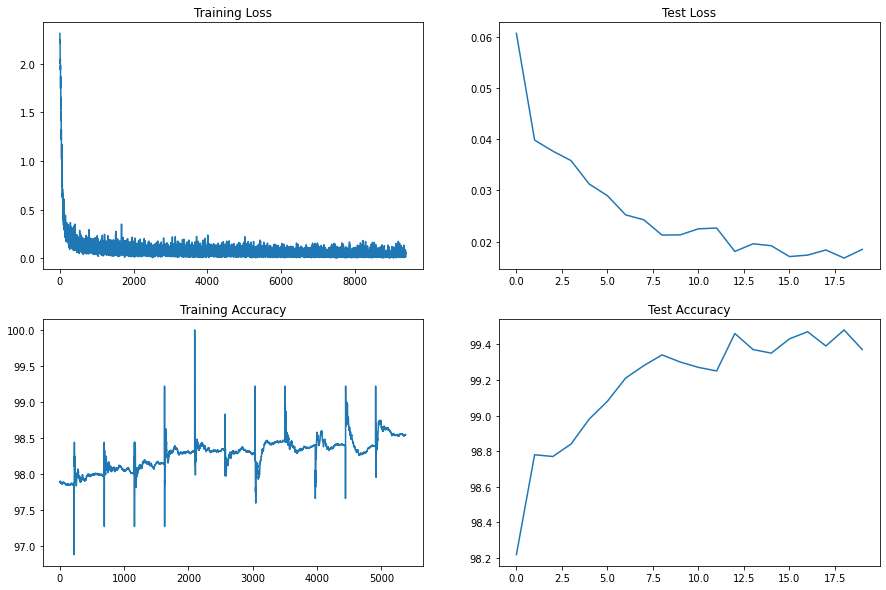

In [10]:
%matplotlib inline
import matplotlib.pyplot as plt

fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(train_losses)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc[4000:])
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")

In [11]:
import pandas as pd

In [12]:
df = pd.DataFrame()
df['batch_avg_train_acc'] = pd.DataFrame(train_acc).rolling(469).mean().dropna()[::469].reset_index(drop=True)[0]
df['train_acc'] = pd.DataFrame(train_acc)[468::469].reset_index(drop=True)[0]
df['test_acc'] = pd.DataFrame(test_acc)
df['train_losses'] = pd.DataFrame([x.item() for x in train_losses])[468::469].reset_index(drop=True)[0]
df['test_losses'] = pd.DataFrame(test_losses)
df[['test_acc', 'train_acc', 'batch_avg_train_acc', 'train_losses', 'test_losses']]

,test_acc,train_acc,batch_avg_train_acc,train_losses,test_losses
0,98.22,87.391667,72.757731,0.202811,0.060685
1,98.78,96.180000,95.964826,0.135819,0.039841
2,98.77,96.906667,96.775971,0.110439,0.037687
3,98.84,97.215000,97.277425,0.066932,0.035835
4,98.98,97.525000,97.534992,0.073821,0.031252
5,99.08,97.698333,97.724997,0.209208,0.028980
6,99.21,97.805000,97.722645,0.144985,0.025233
7,99.28,97.836667,97.775862,0.017848,0.024265
8,99.34,97.870000,97.832926,0.070362,0.021283
9,99.30,97.958333,97.966961,0.103471,0.021326


In [16]:
df[:].max()

batch_avg_train_acc    98.572660
train_acc              98.541667
test_acc               99.480000
train_losses            0.209208
test_losses             0.060685
dtype: float64

# Results:
* Parameters: 9,958
* Best Training Accuracy: 98.35% (EPOCH 14)
* Best Test Accuracy: 99.46% (EPOCH 13) 99.48 (EPOCH 19)
 
# Analysis:
* by adding step lr and Dropout of 0.05, the training is even more stable.
* consistent test accuracy around 99.4 observed from epoch 13.
* The LR was reduced at EPOCH 12.
* Since the model is underfitting till EPOCH 20, training for more epochs OR removing regularizations would be helpful.

In [18]:
max_test_epoch = 13
df[['test_acc', 'train_acc']][max_test_epoch - 3:max_test_epoch + 6]

,test_acc,train_acc
10,99.27,98.016667
11,99.25,98.130000
12,99.46,98.310000
13,99.37,98.353333
14,99.35,98.291667
15,99.43,98.453333
16,99.47,98.396667
17,99.39,98.380000
18,99.48,98.391667


In [19]:
df.min()

batch_avg_train_acc    72.757731
train_acc              87.391667
test_acc               98.220000
train_losses            0.014696
test_losses             0.016792
dtype: float64

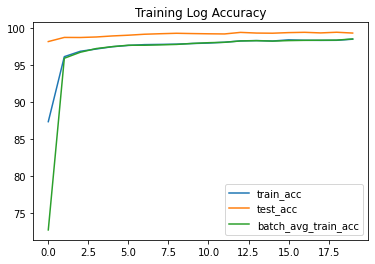

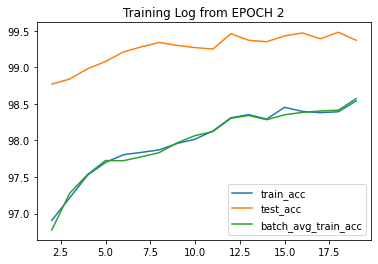

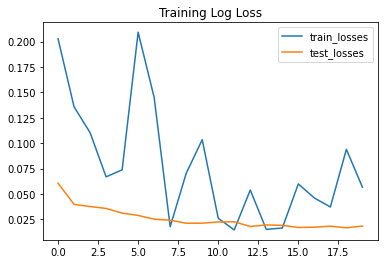

In [20]:
df[['train_acc', 'test_acc', 'batch_avg_train_acc']].plot(title="Training Log Accuracy")
df[['train_acc', 'test_acc', 'batch_avg_train_acc']][2:].plot(title="Training Log from EPOCH 2")
df[['train_losses', 'test_losses']].plot(title="Training Log Loss")

In [21]:
df[15:].var()

batch_avg_train_acc    7.416167e-03
train_acc              4.514722e-03
test_acc               2.320000e-03
train_losses           4.672616e-04
test_losses            5.874813e-07
dtype: float64

In [22]:
## inspect data
model.eval()
test_loss = 0
correct = 0

wrong_correct = []
wrong_predicted = []
wrong_image_data = []

with torch.no_grad():
    for data, target in test_loader:
        data, target = data.to(device), target.to(device)
        output = model(data)
        # test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
        pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
        status = pred.eq(target.view_as(pred))
        # correct += status.sum().item()

        mistakes, _ = torch.where(status==False)
        if len(mistakes):
          m_data = data[mistakes]
          m_target = target[mistakes]
          m_output = output[mistakes]
          m_pred = pred[mistakes]
          correct = [x.item() for x in m_target.cpu().detach()]
          predicted = [x.item() for x in m_pred.cpu().detach()]
          image_data = [x for x in m_data.cpu().detach()]

          wrong_correct.extend(correct)
          wrong_predicted.extend(predicted)
          wrong_image_data.extend(image_data)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [23]:
from collections import Counter

In [24]:
len(wrong_correct), len(wrong_predicted), len(wrong_image_data)

(63, 63, 63)

In [25]:
mskts = pd.DataFrame(Counter(wrong_correct).most_common(), columns=['number', 'number of times prediction error'])
mskts

,number,number of times prediction error
0,7,15
1,5,10
2,6,9
3,8,9
4,9,7
5,4,4
6,2,4
7,0,3
8,3,2


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).



Correct Label -- 7 || Mistakenly predicted as [9, 1, 1, 2, 2, 9, 2, 9, 2, 1, 1, 1, 9, 9, 2]


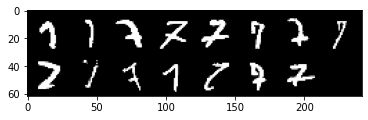

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).



Correct Label -- 5 || Mistakenly predicted as [3, 3, 3, 3, 6, 3, 6, 3, 0, 3]


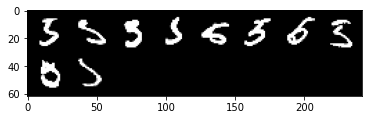

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).



Correct Label -- 6 || Mistakenly predicted as [1, 5, 0, 0, 8, 1, 1, 8, 0]


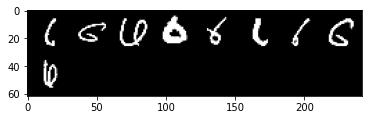

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).



Correct Label -- 8 || Mistakenly predicted as [4, 0, 9, 3, 5, 3, 9, 9, 0]


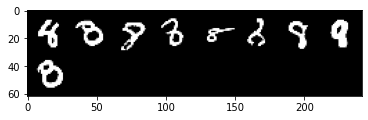

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).



Correct Label -- 9 || Mistakenly predicted as [4, 5, 4, 5, 4, 4, 5]


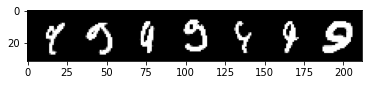


Correct Label -- 4 || Mistakenly predicted as [9, 9, 9, 1]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


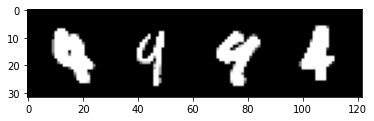


Correct Label -- 2 || Mistakenly predicted as [1, 1, 7, 0]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


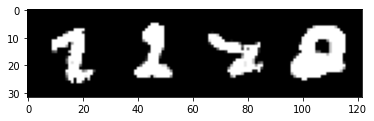

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).



Correct Label -- 0 || Mistakenly predicted as [6, 2, 7]


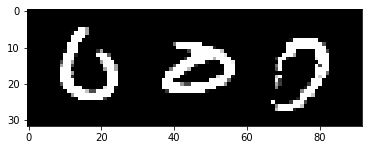

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).



Correct Label -- 3 || Mistakenly predicted as [5, 8]


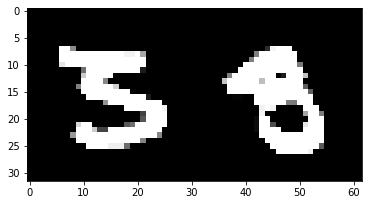

In [26]:
for select_num in mskts['number']:
  # select_num = 9
  img_data_temp = []
  wps = []
  for wc, wp, wi in zip(wrong_correct, wrong_predicted, wrong_image_data):
    if wc == select_num:
      wps.append(wp)
      img_data_temp.append(wi)

  wrong_images_temp = torch.stack(img_data_temp)
  print()
  print(f"Correct Label -- {select_num} || Mistakenly predicted as {wps}")

  grid_img = torchvision.utils.make_grid(wrong_images_temp)
  plt.imshow(grid_img.permute(1, 2, 0))
  plt.show()